# imports


In [1]:
# %pip install seaborn
# %pip install ipykernel
# pip install -r requirements.txt

https://habr.com/ru/companies/ods/articles/323730/  -- со ссылками на другие примеры и датасеты


https://education.yandex.ru/handbook/ml/article/vremennye-ryady

https://sky.pro/wiki/profession/analiz-istoricheskih-dannyh-dlya-prognozirovaniya-vyruchki/

https://habr.com/ru/companies/ecom_tech/articles/698118/ №№ теория

https://habr.com/ru/articles/207160/ --ARIMA



lstm
https://habr.com/ru/articles/505338/
https://practicum.yandex.ru/blog/neyroset-lstm-dlya-mashinnogo-obucheniya/



In [42]:
import datetime as dt
from datetime import date
import os
from dotenv import load_dotenv

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import mysql.connector as myPy
from mysql.connector import Error
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose #для статистических моделей (ARIMA, экспоненциальное сглаживание)
from prophet import Prophet # для моделей машинного обучения
from sklearn.metrics import root_mean_squared_error as rmse,  r2_score, mean_absolute_percentage_error

# connect

In [3]:
connector_parametrs = {'host':"localhost",
                        'port':3306,
                        'dbname':'crmsql',
                        'user':'root',
                        'password':'Sansay1'
                        }


# for products

In [15]:
try:
    connector = myPy.connect(host=connector_parametrs['host'],
                        port=connector_parametrs['port'],
                        database=connector_parametrs['dbname'],
                        user=connector_parametrs['user'],
                        password=connector_parametrs['password'])
    
    query = """SELECT date, product_id, 
			        count(product_id)*price AS revenue
                FROM sales
	                INNER JOIN price USING (product_id)
                GROUP BY  1, 2
                ORDER BY 1"""
    df_sales_dymanic = pd.read_sql(query, connector)

except Error as e:
    print(f'Ошибка:{e}')

finally:
    if connector and connector.is_connected():
        connector.close()
        print('Соединение закрыто вручную')


# display(df_sales_dymanic[df_sales_dymanic['product_id'] == 1].head())


C:\Users\aigna\AppData\Local\Temp\ipykernel_20948\3651149323.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_sales_dymanic = pd.read_sql(query, connector)


Соединение закрыто вручную


Text(0, 0.5, 'Выручка')

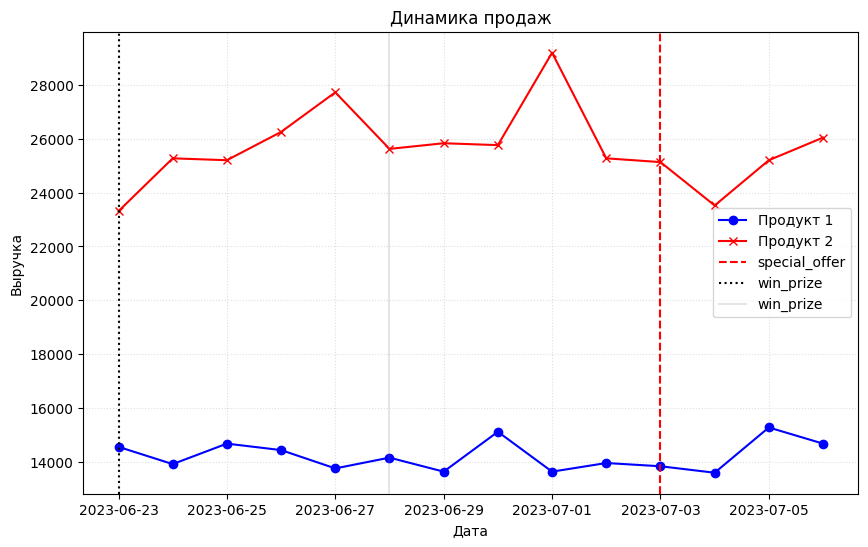

In [16]:
df_sales_dymanic['date'] = pd.to_datetime(df_sales_dymanic['date'])

# df_sales_dymanic['revenue'].hist()
figure_dinamic_prod1 = plt.figure(figsize= (10,6))
plt.plot(df_sales_dymanic[df_sales_dymanic['product_id'] == 1]["date"],df_sales_dymanic[df_sales_dymanic['product_id'] == 1]['revenue'], label='Продукт 1', marker='o', color='blue')
plt.plot(df_sales_dymanic[df_sales_dymanic['product_id'] == 2]["date"],df_sales_dymanic[df_sales_dymanic['product_id'] == 2]['revenue'], label='Продукт 2', marker='x', color='red')
# plt.plot(df_sales_dymanic["date"],df_sales_dymanic['revenue'], label='Продукт 2', marker='x', color='red')
# plt.scatter(data = df_sales_dymanic[df_sales_dymanic['product_id'] == 1], x="date", y = 'revenue')
# Добавляем вертикальную линию для конкретной даты
plt.axvline(x=dt.date(2023, 7, 3), color='red', linestyle='--', label='special_offer')
plt.axvline(x=dt.date(2023, 6, 23), color='black', linestyle=':', label='win_prize')
plt.axvline(x=dt.date(2023, 6, 28), color='grey', linestyle='-', label='win_prize', alpha = 0.2)

plt.title("Динамика продаж")
plt.legend()
plt.grid(True, linestyle=':', alpha=0.4)
plt.xlabel("Дата")
plt.ylabel("Выручка")

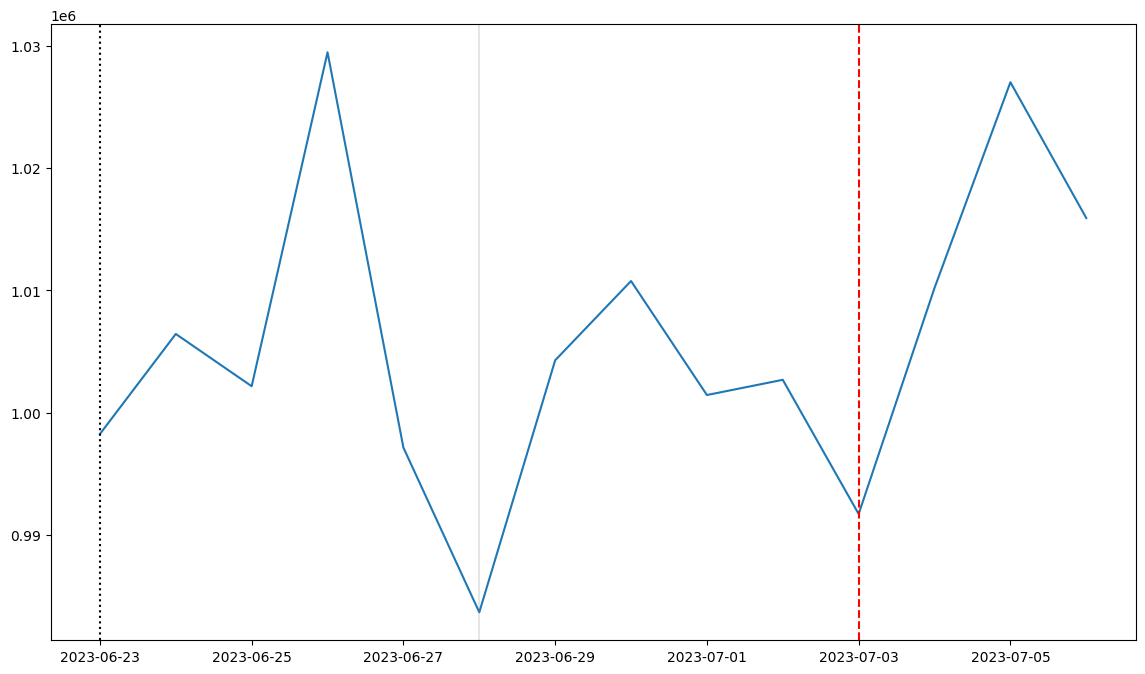

In [17]:
df_grop_date = df_sales_dymanic.groupby(by='date', as_index=False).agg(all_sales =('revenue', 'sum'))
fig_all_sales = plt.figure(figsize=(14, 8))
plt.plot(df_grop_date['date'], df_grop_date['all_sales'])
plt.axvline(x=dt.date(2023, 7, 3), color='red', linestyle='--', label='special_offer')
plt.axvline(x=dt.date(2023, 6, 23), color='black', linestyle=':', label='win_prize')
plt.axvline(x=dt.date(2023, 6, 28), color='grey', linestyle='-', label='win_prize', alpha = 0.2)


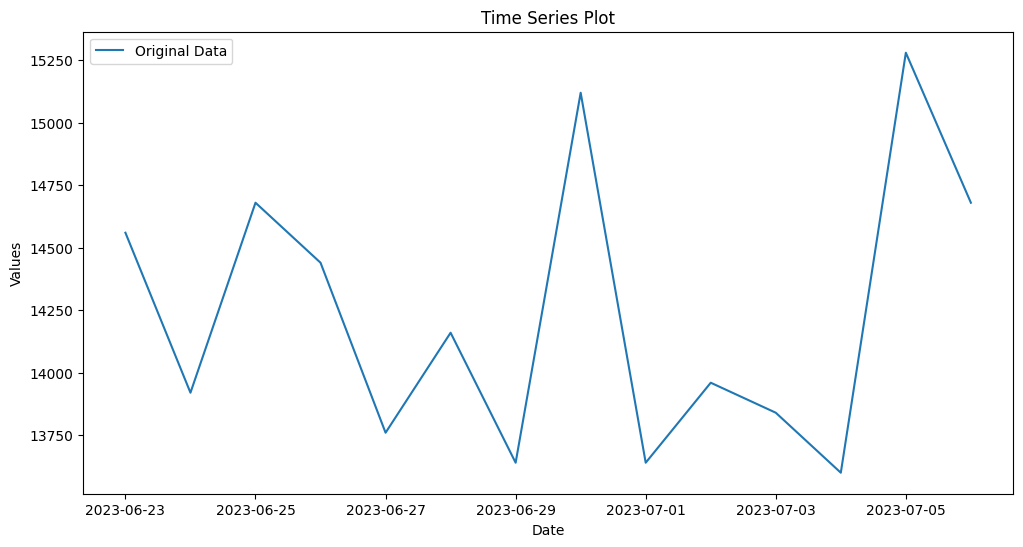

In [18]:
df_1 = df_sales_dymanic[df_sales_dymanic['product_id'] == 1]
df_1.set_index('date', inplace=True)
df_1

plt.figure(figsize=(12, 6))
plt.plot(df_1.index, df_1['revenue'], label='Original Data')
plt.title('Time Series Plot')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.show()

In [ ]:
result = seasonal_decompose(df_1['revenue'], model='additive') 
result

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12,8))
axes[0].plot(result.observed, color="black")
axes[0].set_title("Observed")
axes[1].plot(result.trend, color="blue")
axes[1].set_title("Trend")
axes[2].plot(result.seasonal, color="green")
axes[2].set_title("Seasonality")
axes[3].plot(result.resid, color="red")
axes[3].set_title("Residuals")
plt.tight_layout()
plt.show()

In [ ]:
df_sales_dymanic['Day'] = df_sales_dymanic['date'].apply(lambda x: x.weekday())
df_sales_dymanic

# for customer with promo and date

In [4]:
try:
    connector = myPy.connect(host=connector_parametrs['host'], port=connector_parametrs['port'],database=connector_parametrs['dbname'],
                             user=connector_parametrs['user'], password=connector_parametrs['password'])
    
    query_promo1 = """SELECT Date As Order_date, id_customer, product_id, cell_package_sk,  start_date As Promo_date,  price, SUM(product_id*price) As Revenue
FROM campaning
	INNER JOIN sendings USING (campaning_SD)
	INNER JOIN response USING (cell_package_sk)
	INNER JOIN sales USING(id_customer)
    INNER JOIN price USING(product_id)
GROUP BY 1,2,3, 4, 5"""
    df_promo1 = pd.read_sql(query_promo1, connector)

except Error as e:
    print(f'Ошибка:{e}')

finally:
    if connector and connector.is_connected():
        connector.close()
        print('Соединение закрыто вручную')

# df_promo1[df_promo1['id_customer'] == 16] 
df_promo1['DiffDate'] = df_promo1['Order_date'] - df_promo1['Promo_date']
df_promo1['Promo'] = df_promo1['DiffDate'].apply(lambda x: 1 if ((x <= dt.timedelta(days=3)) & (x>= dt.timedelta(days=0))) else 0)

# df_promo1.sort_values('id_customer')['Res'].value_counts(normalize=True)

# df_promo1.groupby(by= 'cell_package_sk', as_index=False).agg(total_revenue = ('Revenue','sum'))
df_promo1['Day_nm'] = df_promo1['Order_date'].apply(lambda x: x.weekday())
# df_promo1['Month_nm'] = df_promo1['Order_date'].apply(lambda x: x.month())

day_names = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
months = ["Январь", "Февраль", "Март", "Апрель", "Май", "Июнь", "Июль", "Август", "Сентябрь", "Октябрь", "Ноябрь", "Декабрь"]
df_promo1['Week_day'] = df_promo1['Day_nm'].apply(lambda x: day_names[x])
df_promo1['Month'] = df_promo1['Order_date'].apply(lambda x: months[x.month-1])
df_promo1.head(3)

df_sales_clear = df_promo1[['Order_date', 'id_customer', 'price', 'Promo','Week_day','Month', 'Revenue']].sort_values('Order_date').copy()
# display(df_sales_clear.head())
df_sales_clear_promo = df_sales_clear.groupby(by=['Order_date','Promo'], as_index=False).agg(all_sales =('Revenue', 'sum')) #.sort_values('Order_date')
df_sales_clear_promo.head(2)

C:\Users\aigna\AppData\Local\Temp\ipykernel_20948\2431891339.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_promo1 = pd.read_sql(query_promo1, connector)


Соединение закрыто вручную


,Order_date,Promo,all_sales
0,2023-06-23,0,7163710.0
1,2023-06-23,1,4385665.0


In [ ]:
df_promo1.groupby(by=['Order_date', 'product_id', 'Promo'], as_index=False).agg(all_sales =('Revenue', 'sum')).query('product_id	== 1').

In [11]:
df_sales_clear_promo.info()
baseline_model = 1 #iPadGPT example ВыборПеременнойКнопками
# df_sales_clear_promo

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Order_date  26 non-null     object 
 1   Promo       26 non-null     int64  
 2   all_sales   26 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 756.0+ bytes


09:24:24 - cmdstanpy - INFO - Chain [1] start processing
09:24:24 - cmdstanpy - INFO - Chain [1] done processing


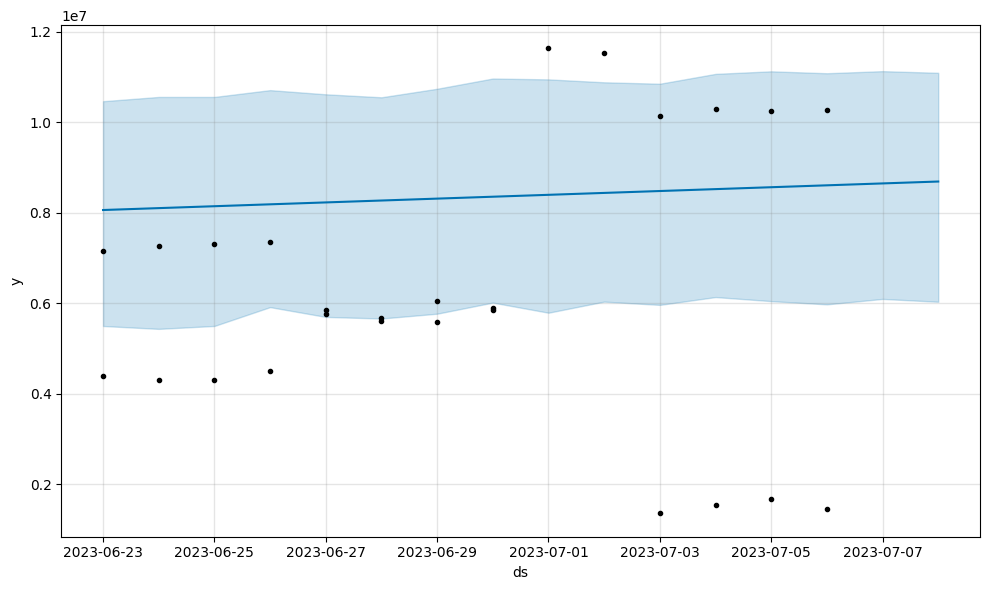

In [13]:
df_propher_promo = df_sales_clear_promo.copy()
df_propher_promo.rename(columns={'Order_date' : "ds", 'all_sales' : "y"}, inplace=True)

# df_propher_promo.loc[len(df_propher_promo), 'Promo'] = 0
# df_propher_promo.loc[len(df_propher_promo), 'Promo'] = 0
# df_propher_promo.tail(4)

model_propher_promo = Prophet()
model_propher_promo.add_regressor('Promo')
model_propher_promo.fit(df_propher_promo)

future_promo_2_days = model_propher_promo.make_future_dataframe(periods=2)

future_promo_2_days['Promo'] = 0

forecast_2_pr = model_propher_promo.predict(future_promo_2_days)

model_propher_promo.plot(forecast_2_pr);  # DeepSeek DaBi

# Propher только для общих объемов по дате

09:27:05 - cmdstanpy - INFO - Chain [1] start processing
09:27:05 - cmdstanpy - INFO - Chain [1] done processing


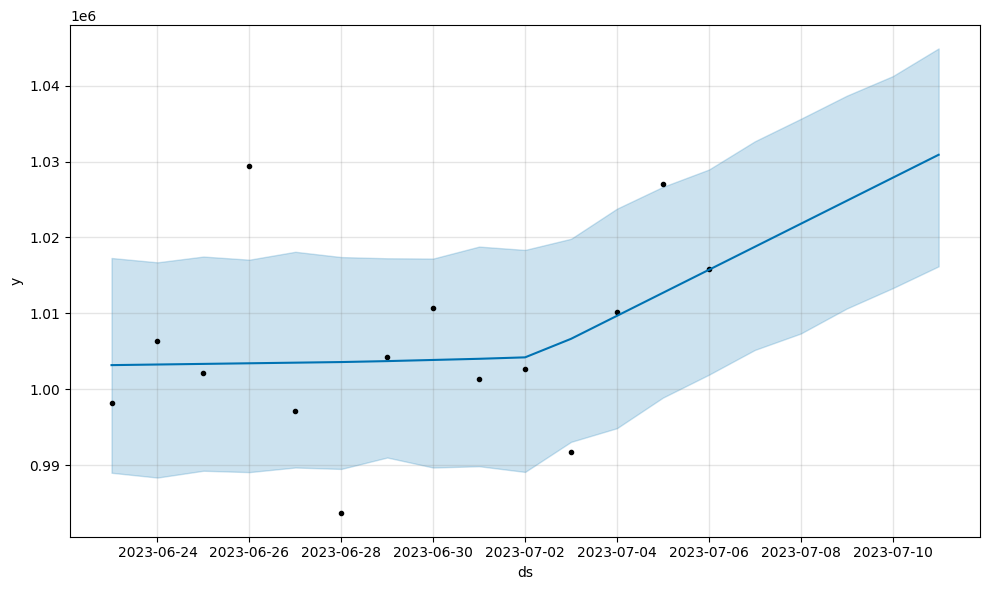

In [19]:
df_propher = df_grop_date.copy()
df_propher.rename(columns={'date' : "ds", 'all_sales' : "y"}, inplace=True)

model_propher = Prophet()
model_propher.fit(df_propher)

future_5_days = model_propher.make_future_dataframe(periods=5)

forcast = model_propher.predict(future_5_days)

# fig = plt.figure(figsize= (10, 5))
# plt.plot(forcast['ds'], forcast['yhat'], marker='o')
# plt.xticks(rotation=45);

model_propher.plot(forcast);

## Prophet regressor fake

In [46]:
dates = pd.date_range('2023-01-01', '2023-06-30', freq='D')
df_fake = pd.DataFrame({
    'ds': dates,
    'y': 100 + 5 * np.sin(2 * np.pi * np.arange(len(dates)) / 30) + 
          np.random.normal(0, 50, len(dates))
})

# plt.scatter(x=df['ds'], y=df['y'])
# # Даты промоакций 
promo_dates = [
    '2023-01-15', '2023-01-16', '2023-01-17',  # 3 дня промо
    '2023-02-10', '2023-02-11',                # 2 дня промо
    '2023-03-20', '2023-03-21', '2023-03-22',  # 3 дня промо
    '2023-04-05', '2023-04-06',  # 2 дня промо
    '2023-05-13', '2023-05-14', '2023-05-15', # 3 дн промо
    '2023-06-14', '2023-06-15'   # 1 дн промо
]

# df['is_promo'] = 0

df_fake['is_promo'] = df_fake['ds'].apply(lambda x: 1 if x in pd.to_datetime(promo_dates) else 0)
# df.query('is_promo == 1')

promo_effect = 140  # Увеличение продаж во время промо
df_fake.loc[df_fake['is_promo'] == 1, 'y'] += promo_effect + np.random.normal(0, 20, sum(df_fake['is_promo']))

# df_fake['y'].plot()

(181, 3)


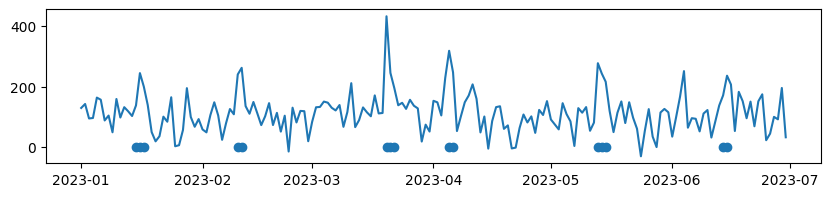

In [47]:
print(f"{df_fake.shape}")
fig = plt.figure(figsize=(10, 2))
plt.plot(df_fake['ds'], df_fake['y'])
plt.scatter(df_fake[df_fake['is_promo'] == 1]['ds'], df_fake[df_fake['is_promo'] == 1]['is_promo'])

df_fake_train = df_fake[:156].copy()
df_fake_test = df_fake[156:].copy()

In [48]:
model_fake = Prophet(yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=0.05) #насколько модель чувствительна к изменениям в динамике данных 0,01 тренд плавный, модель игнорирует мелкие колебания


model_fake.add_regressor('is_promo')

model_fake.fit(df_fake_train)

14:52:34 - cmdstanpy - INFO - Chain [1] start processing
14:52:34 - cmdstanpy - INFO - Chain [1] done processing


In [49]:
future_25_days = model_fake.make_future_dataframe(periods=25, freq='D') # create_datesDS от первого числа + добавить промо для regressor

# future_promo_dates = ['2023-06-14', '2023-06-15']

future_25_days['is_promo'] = 0
future_25_days.loc[future_25_days['ds'].isin(pd.to_datetime(promo_dates)), 'is_promo'] = 1

# future_25_days_WIF = df_fake_test[['ds', 'is_promo']].copy()
# future_25_days['is_promo'].value_counts()
# future_30_days['is_promo'].value_counts()

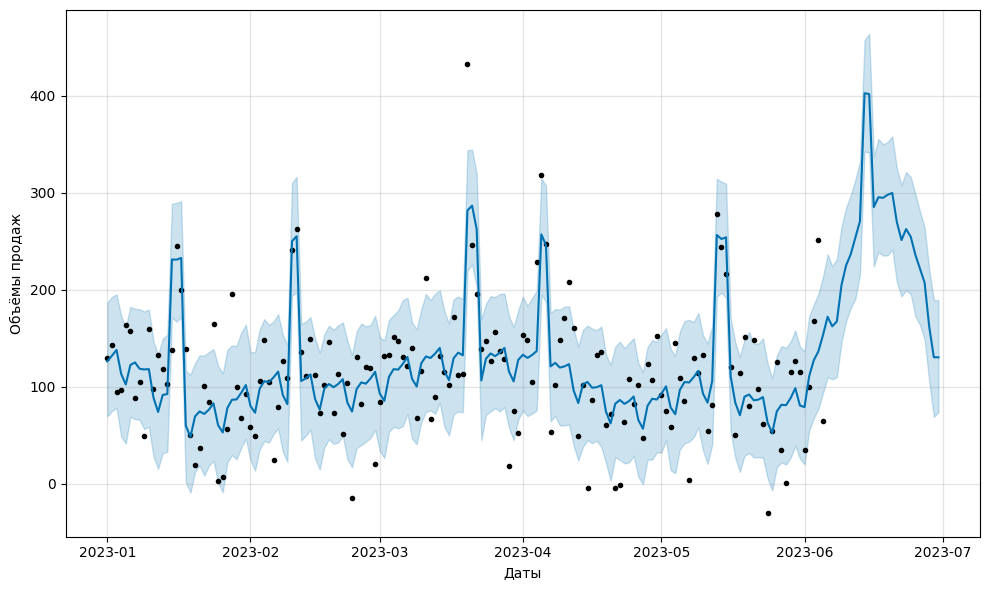

In [50]:
forecast_fake = model_fake.predict(future_25_days)

model_fake.plot(forecast_fake, xlabel= 'Даты', ylabel= 'Объёмы продаж');

# forecast_fake[['ds','yhat']][-25:]
# df_fake

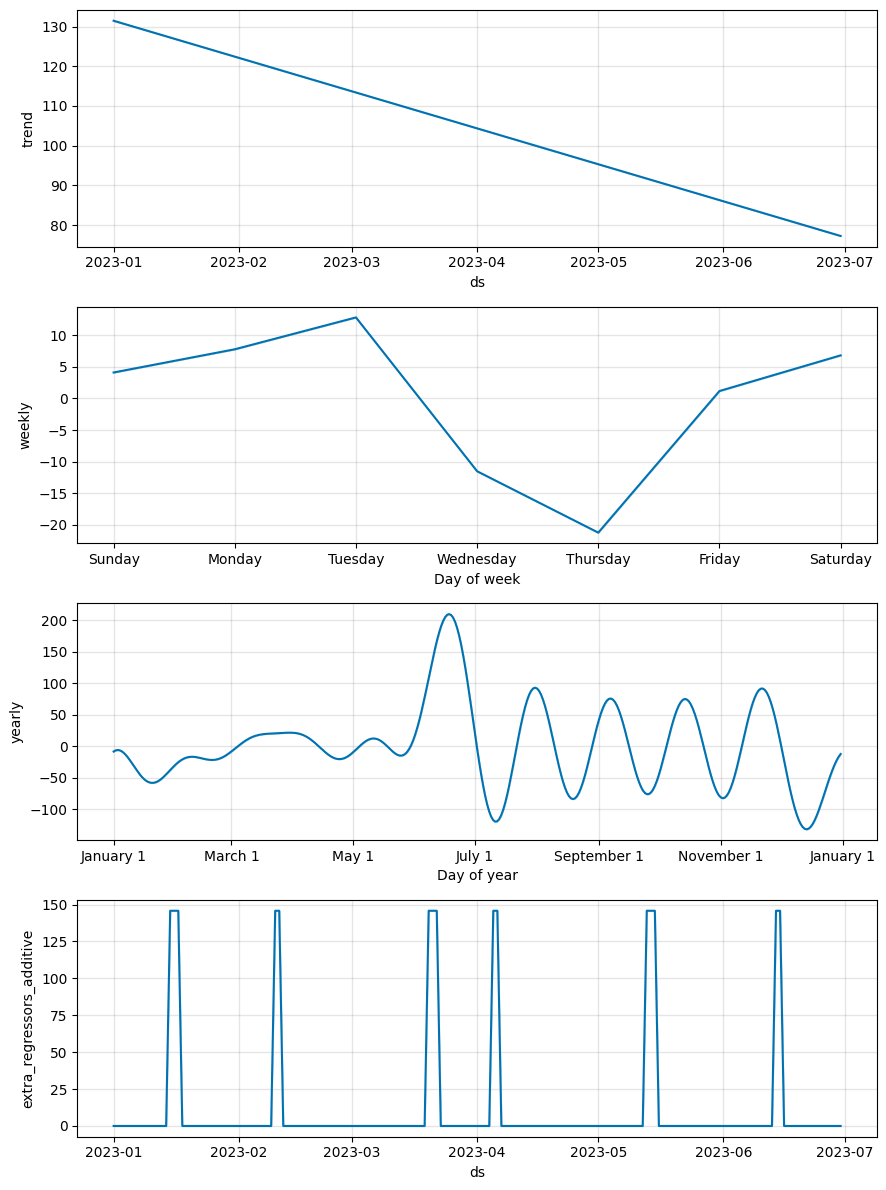

In [51]:
model_fake.plot_components(forecast_fake);

In [52]:
# df_fake[-25:]

# df_metrix = pd.concat([df_fake[-25:], forecast_fake[['ds','yhat']][-25:]], axis=1)
df_metrix = df_fake[-25:].merge(forecast_fake[['ds','yhat']][-25:], on='ds')
df_metrix['error'] = df_metrix['y'] - df_metrix['yhat']
df_metrix['MAPE'] = abs(df_metrix['error'] / df_metrix['y'])
df_metrix['SE'] = df_metrix['error']**2
df_metrix

MAPE_fake = df_metrix['MAPE'].mean()
RMSE_fake = rmse(df_metrix['y'], df_metrix['yhat'] )
DISP = df_metrix['y'].var()
DISP_fake = df_metrix['yhat'].var()
R2 = (DISP_fake/DISP)
k_determ = r2_score(df_metrix['y'], df_metrix['yhat'])
print(f"Метрики модели   \
    \n r^2: {R2:.2f}, \
    \n r^2bibl: {k_determ:.2f}, \
    \n MAPE: {MAPE_fake:.1%},\
    \n RMSE: {RMSE_fake:.1f},")

Метрики модели       
 r^2: 1.39,     
 r^2bibl: -5.13,     
 MAPE: 193.4%,    
 RMSE: 144.8,


## fake  baseline ARIMAX

In [53]:
df_fake_arimax = df_fake[['ds', 'y']].copy()
df_fake_arimax.set_index('ds', inplace=True)
# df_fake_arimax[-25:].index

In [54]:
test = sm.tsa.adfuller(df_fake_arimax)
print(f'adf:  {test[0]:.1f} \n\
p-value:  {test[1]:.1%}\n\
Critical values 5%:  {test[4]["5%"]:.1f}')
if test[0]> test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -9.2 
p-value:  0.0%
Critical values 5%:  -2.9
единичных корней нет, ряд стационарен


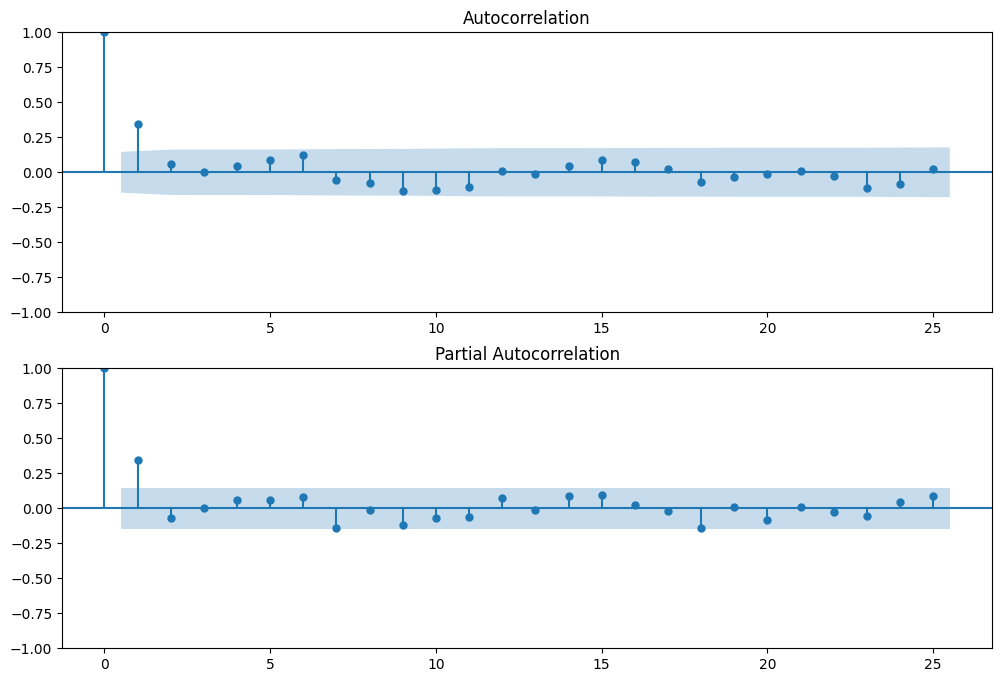

In [55]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_fake_arimax.values.squeeze(), lags=25, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_fake_arimax, lags=25, ax=ax2)


In [56]:
src_data_model = df_fake_arimax[:-25]
model_arimax = sm.tsa.arima.ARIMA(src_data_model, order=(0,1,1), trend='t', freq='D').fit()
print(model_arimax.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  156
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -870.773
Date:                Fri, 14 Nov 2025   AIC                           1747.546
Time:                        14:53:19   BIC                           1756.676
Sample:                    01-01-2023   HQIC                          1751.255
                         - 06-05-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0279      1.281     -0.022      0.983      -2.538       2.482
ma.L1         -0.7814      0.053    -14.795      0.000      -0.885      -0.678
sigma2      4410.9300    355.070     12.423      0.0

c:\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [57]:
df_fake[-25:]

,ds,y,is_promo
156,2023-06-06,95.828394,0
157,2023-06-07,93.884535,0
158,2023-06-08,52.202685,0
159,2023-06-09,111.156195,0
160,2023-06-10,122.738441,0
161,2023-06-11,31.820438,0
162,2023-06-12,85.246325,0
163,2023-06-13,137.831226,0
164,2023-06-14,171.370879,1
165,2023-06-15,236.309143,1


In [59]:
pred_arimax  = model_arimax.predict('2023-06-06','2023-06-30')
trn = df_fake['y'][-25:]
r2_arima = r2_score(trn, pred_arimax)
rmse_arima =  rmse(trn, pred_arimax)
MAPE_arimax =  mean_absolute_percentage_error(trn, pred_arimax)
print(f'Индекс детерминации {r2_arima:.1%} \n\
      RMSE: {rmse_arima:.1f}\n\
      MAPE: {MAPE_arimax:.1%}');



Индекс детерминации -0.4% 
      RMSE: 58.6
      MAPE: 76.3%
